## Probni program
Nastavimo zacetne pogoje za program. 
### Generator tock
Najprej generiramo nakljucno n tock v ravnini s pomocjo funkcije generate_random_points, ki vrne seznam z generiranim tock v prostoru $[0,10)\times[0,10)$.

In [8]:
def generate_random_points(n, max_x = 10, max_y = 10):
    return [(max_x * random(), max_y * random()) for _ in range(n)]

Izberemo n tock:
[(7.162767330842009, 0.5626968597182269), (5.957975369719689, 6.015387010534331), (2.195217122145138, 6.046047527887529), (8.246914849640651, 7.36261974194094), (8.449252947080643, 6.002577985950168), (7.211619643126839, 5.695252826985709), (6.199968358044227, 0.7289170605615236)]


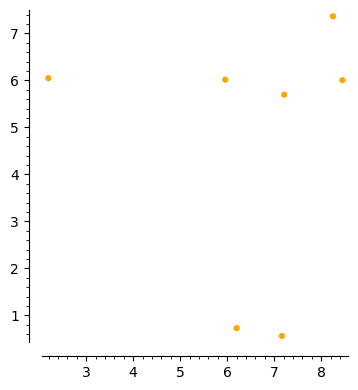

In [24]:
# Probamo to funckijo in narisemo tocke
print("Izberemo n tock:")
n = 7
list_points = generate_random_points(n)
print(list_points)

plot_points = list_plot(list_points, color = "orange", pointsize = 20)
show(plot_points, aspect_ratio=1)

### Razdalja med tockami
S pomocjo funkico distance, naredimo seznam-distances, ki vsebuje razdaljo med vsemi generirani tock.

In [25]:
def distance(p, q):
    return math.sqrt((p[0] - q[0])^2 + (p[1] - q[1])^2)

In [26]:
# Poskusimo funkcijo na zgoraj generirane tocke
# indeksiramo razdalja med vsema vozliscama

distances = {Set([i, j]): distance(list_points[i], list_points[j])
             for i in range(len(list_points)) for j in range(i+1, len(list_points))}

### Presecisca daljic
Nasljedno funckijo nam pove ali se dve daljici (segmenti) sekajo. S pomocjo to funkcijo bomo naredili matriko presecisc.

In [27]:
# Funkcija orientation pove kaksna je orientacija med trema tockama
# orientacija je 0/1/-1 ce so tocke kolinearno/clockwise/counterclockwise orientirane

def orientation(p, q, r):

    val = ((q[1] - p[1]) * (r[0] - q[0])) - ((q[0] - p[0]) * (r[1] - q[1]))
    
    if val == 0 : 
        return 0
    elif val > 0:
        return 1
    else:
        return -1

# Funckija on_segment preveri ali se tocka r nahaja na segment med tocke p in q
# Vrni True/Flase ce je/ni na segmentu (p,q)

def on_segment(p, q, r):

    # r[0] je v intervalu (min(p[0], q[0]), max(p[0], q[0])) in
    # r[1] je v intervalu (min(p[1], q[1]), max(p[1], q[1]))

    if r[0] <= max(p[0], q[0]) and r[0] >= min(p[0], q[0]) and r[1] <= max(p[1], q[1]) and r[1] >= min(p[1], q[1]):
        return True
    return False

# Funckija intersects preveri ali se dva segmenta sekajo
# Vrne True/False ce se seg1 in seg2 sekajo/ne sekajo

def intersects(seg1, seg2):

    # seg1 = (p1, p2) = ((p1[0], p1[1]), ((p2[0], p2[1]))
    # seg2 = (p3, p4) = ((p3[0], p3[1]), ((p4[0], p4[1]))
    
    # get the points
    p1, q1 = seg1
    p2, q2 = seg2
    
    if p1 == p2:
        return False
    elif p1 == q2:
        return False
    elif q1 == p2:
        return False
    elif q1 == q2:
        return False
    
    # find all orientations
    
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # check general case 
    # (p1, q1, p2) and (p1, q1, q2) have different orientations and
    # (p2, q2, p1) and (p2, q2, p2) have different orientations
    
    if o1 != o2 and o3 != o4:
        return True
    
    # check special cases
    # (p1, q1, p2), (p1, q1, q2), (p2, q2, p1), (p2, q2, p2) are all collinear and
    # the x-projections of (p1, q1) and (p2, q2) intersect and
    # the y-projections of (p1, q1) and (p2, q2) intersect
    
    if o1 == 0 and on_segment(p1, q1, p2) : return True
    if o2 == 0 and on_segment(p1, q1, q2) : return True
    if o3 == 0 and on_segment(p2, q2, p1) : return True
    if o4 == 0 and on_segment(p2, q2, q1) : return True

    
    return False
    

In [28]:
# Naredimo matrika(seznam senzamov),
# ki nam pove ali se dve daljici sekajo med saboj.
# Ce se daljici seg1 in seg2, med tocki p1, p2 in p3, p4 sekajo 
# potem je vrednost v matriki 1, sicer je 0

intersection = [] # seznam, ki pove kateri povezavi med vsemi vozlisca se sekajo med saboj
it = iter(distances) # iterator gre skozi ključe slovarja distances - to so ravno povezave grafa

for e in it: # za vsako povezavo
    
    seg1 = [list_points[i] for i in e]
    jt = copy(it) # kopija iteratorja - da se obravnava vsak par povezav enkrat
    
    for f in jt:
        seg2 = [list_points[i] for i in f]
        if intersects(seg1, seg2):
            intersection.append((e, f))

### Linearni program
Poskusimo linearni program brez narejeni graph.

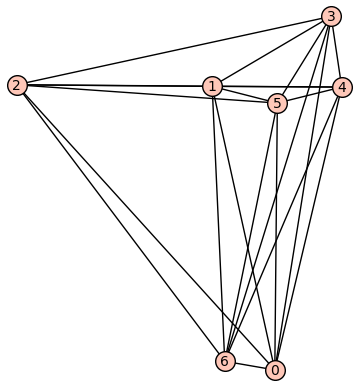

In [29]:
g = graphs.CompleteGraph(len(list_points))
g._pos = dict(enumerate(list_points))
g.plot()

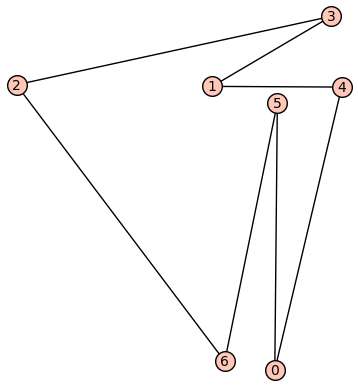

In [32]:
# Linearni program 1
# Maksimizacija skupna dolzina uporabljenih povezav

p = MixedIntegerLinearProgram()
x = p.new_variable(binary=True)

# define the objective function
# ciljna funkcija: max skupna dolžina uporabljenih povezav
p.set_objective(sum(x[e] * d for e, d in distances.items())) 

# POGOJI

# če se povezavi sekata, smemo uporabiti največ eno
for e, f in intersection:
    p.add_constraint(x[e] + x[f] <= 1)
    
for v in g.vertices():
    edges = g.edges_incident(v, labels = False)
    p.add_constraint(sum(x[Set(e)] for e in edges) == 2)

p.solve()

while True:
    
    x_sol = p.get_values(x)
    edges = [tuple(e) for e, i in x_sol.items() if i == 1]
    #print(edges)
    g_tmp = g.subgraph(vertices = g.vertices(), edges = edges)
    cc = g_tmp.connected_components()
    
    if len(cc) == 1:
        break
        
    boundary = g.edge_boundary(cc[0], labels = False)
    
    p.add_constraint(sum([x[e] for e in boundary]) >= 2)
    p.solve()
    
value = p.solve()
solution = p.get_values(x)
g_tmp.plot()

In [106]:
# Linearni program 2
# Maksimizacije dolžine najkrajše uporabljene povezave

p = MixedIntegerLinearProgram()
x = p.new_variable(binary=True)

# define the objective function
# ciljna funkcija: max skupna dolžina uporabljenih povezav
p.set_objective(x[e] * d for e, d in distances.items())

# POGOJI

# 
#povezava = None
#min_f = max(distances.values())
        
# če se povezavi sekata, smemo uporabiti največ eno
for e, f in intersection:
    p.add_constraint(x[e] + x[f] <= 1)
    
for v in g.vertices():
    edges = g.edges_incident(v, labels = False)
    p.add_constraint(sum(x[Set(e)] for e in edges) == 2)

p.solve()

while True:
    
    x_sol = p.get_values(x)
    edges = [tuple(e) for e, i in x_sol.items() if i == 1]
    g_tmp = g.subgraph(vertices = g.vertices(), edges = edges)
    cc = g_tmp.connected_components()
    
    if len(cc) == 1:
        break
        
    boundary = g.edge_boundary(cc[0], labels = False)
    
    p.add_constraint(sum([x[e] for e in boundary]) >= 2)
    
    p.solve()

# uporabi povezavo ki ima najmanjso dolzino
for e, l in distances.items():
    p.add_constraint((x[e] if l == min(distances.values())) == 1)
    
value = p.solve()
solution = p.get_values(x)

SyntaxError: invalid syntax (<ipython-input-106-fbb5ef3a6486>, line 45)